In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-ViCTSD"
%cd /content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-ViCTSD
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/Dataset/UIT-ViCTSD
UIT-ViCTSD_test_text.csv  UIT-ViCTSD_train.csv	UIT-ViCTSD_valid.csv


# 1. Import thư viện

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 3.3MB 23.2MB/s 
     |████████████████████████████████| 901kB 30.0MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

# 2. Load data

In [ ]:
train = pd.read_csv(path + "/UIT-ViCTSD_train.csv", index_col=False)
dev = pd.read_csv(path + "/UIT-ViCTSD_valid.csv", index_col=False)
test = pd.read_csv(path + "/UIT-ViCTSD_test_text.csv", index_col=False)

X_train = train['Comment']
y_train = train['Toxicity'].values

X_dev = dev['Comment']
y_dev = dev['Toxicity'].values

# X_test = test['Comment']
# y_test = test['Toxicity'].values

In [ ]:
# Create object "le" to encoding label 
le = LabelEncoder()
le.fit(y_train)
y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
# y_test_encoding = le.transform(y_test)

In [ ]:
num_labels = len(np.unique(y_train))
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 3. XLM-R

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels = num_labels)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [ ]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-ViCTSD/Toxicity/results_1
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-ViCTSD/Toxicity/results_1
results


In [ ]:
# encoding du lieu

train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
# test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
# test_dataset = BuildDataset(test_encodings, y_test_encoding)

# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# huan luyen mo hinh

trainer.train()

Step,Training Loss
500,0.348300
1000,0.246600
1500,0.145500
2000,0.101500
2500,0.059100
3000,0.041000
3500,0.034800
4000,0.023200
4500,0.024100
5000,0.021900


TrainOutput(global_step=21900, training_loss=0.028825939034713012, metrics={'train_runtime': 15024.9932, 'train_samples_per_second': 1.458, 'total_flos': 853087117877760.0, 'epoch': 100.0, 'init_mem_cpu_alloc_delta': 400433152, 'init_mem_gpu_alloc_delta': 1112255488, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -72933376, 'train_mem_gpu_alloc_delta': 3356091904, 'train_mem_cpu_peaked_delta': 855482368, 'train_mem_gpu_peaked_delta': 930201088})

# Lấy File y_Predicted

In [ ]:
X_test = test['Comment']
test['Toxicity'] = 0
y_test = test['Toxicity'].values #Gán cho y_test giá trị constant= 0 để đủ 2 cột đưa vào hàm
test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)
y_test_encoding = le.transform(y_test)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
 # Du doan 
y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
import pandas as pd

pd.DataFrame({"Y_Prediced": y_pred}).to_csv('XLM-R_ViCTSD_Toxicity.csv', index= False)

# Đánh giá kết quả

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-ViCTSD
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/Dataset/UIT-ViCTSD
LabelTest.json	UIT-ViCTSD_test_text.csv  UIT-ViCTSD_valid.csv
Test.csv	UIT-ViCTSD_train.csv


In [3]:
import pandas as pd
labelTest= pd.read_json("/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-ViCTSD/LabelTest.json")
labelTest.head()

,,id,comment,constructiveness,toxicity,title,topic
0,0,6252,Người ăn không hết kẻ lần chẳng ra,0,1,28 năm chịu đựng bộ ngực khổng lồ,SucKhoe
1,1,4684,Nhiều người cứ nghĩ đạp xe là văn minh. haizzzz,0,1,Cả trăm người đạp xe thể dục bịt kín đường,OtoXemay
2,2,1731,Rất văn hoá,0,0,Cô gái được bố nhắn nhủ ba từ mỗi ngày,GiaoDuc
3,3,4742,Đời ta ba mươi đời nó. Mua chiếc xe cũng chỉ p...,0,0,Các loại phụ kiện ôtô đại lý hay chào khách,OtoXemay
4,4,4521,"Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật,...",1,1,Ba người thoát chết dưới bánh xe bồn,OtoXemay


In [4]:
# Đọc file labels predict lên
labelPred= pd.read_csv('/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-ViCTSD/Toxicity/results_1/XLM-R_ViCTSD_Toxicity.csv')
labelPred.head()

,Y_Prediced
0,1
1,0
2,0
3,0
4,1


In [ ]:
# Đánh giá:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = labelTest.toxicity
#y_pred_classify = model_lstm_cnn.predict(x_test_seq)
#y_pred = y_pred_classify.argmax(axis=-1)
y_pred = labelPred

cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_true).astype(str).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels= pd.Series(y_true).unique(), target_names=target_names))

[[ 44  66]
 [ 33 857]]
accuracy: 0.901
F1 - macro: 0.70799130462996
Classification report in Training set
              precision    recall  f1-score   support

           1       0.57      0.40      0.47       110
           0       0.93      0.96      0.95       890

    accuracy                           0.90      1000
   macro avg       0.75      0.68      0.71      1000
weighted avg       0.89      0.90      0.89      1000



In [7]:
import numpy as np
import seaborn as sn

In [5]:
# Đánh giá:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = labelTest.toxicity
#y_pred_classify = model_lstm_cnn.predict(x_test_seq)
#y_pred = y_pred_classify.argmax(axis=-1)
y_pred = labelPred

cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_true).astype(str).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels= pd.Series(y_true).unique(), target_names=target_names))

[[ 44  66]
 [ 33 857]]
accuracy: 0.901
F1 - macro: 0.70799130462996
Classification report in Training set
              precision    recall  f1-score   support

           1       0.57      0.40      0.47       110
           0       0.93      0.96      0.95       890

    accuracy                           0.90      1000
   macro avg       0.75      0.68      0.71      1000
weighted avg       0.89      0.90      0.89      1000



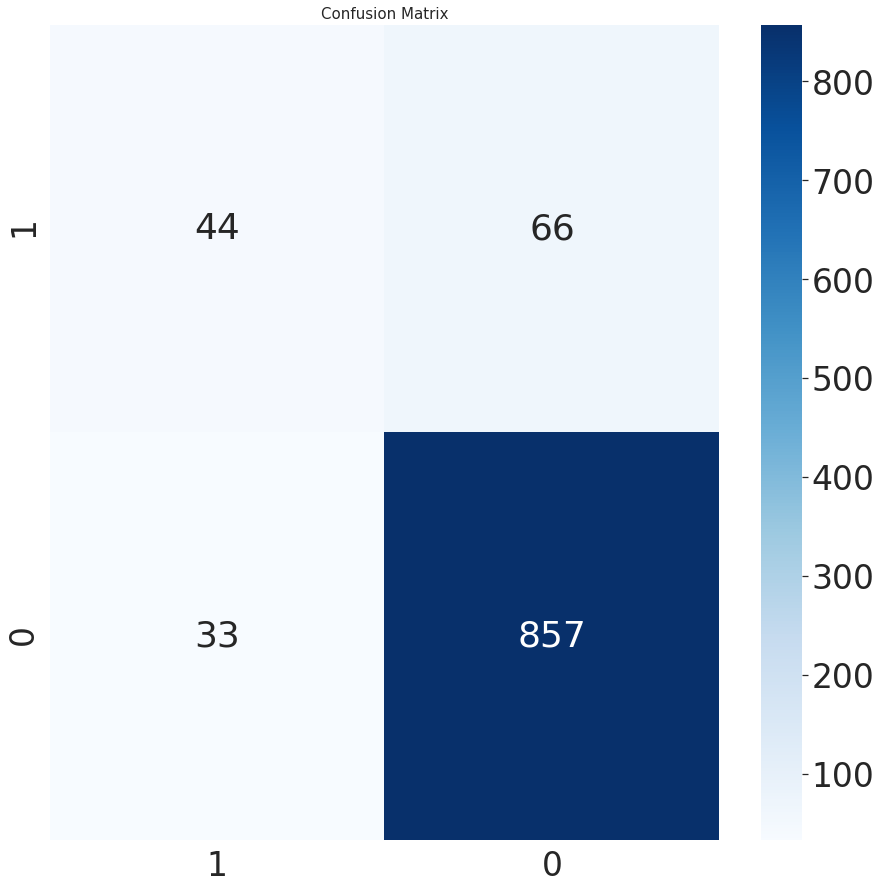

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ve ma tran nham lan
plt.figure(figsize=(15,15))
df_cm = pd.DataFrame(cf, index = target_names,
                  columns = target_names)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit

# Labels, title and ticks
label_font = {'size':'15'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'15'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

sns.heatmap(df_cm, annot=True, ax=ax, cmap="Blues", fmt="g");  
sns.heatmap(df_cm, annot=False, cmap="Blues",fmt='g', cbar=False, annot_kws={"size": 10})